<div style="background-color: #ffffff; color: #333; padding: 15px; border: 1px solid #ddd; border-radius: 8px;">
    <a class="anchor" id="1st-bullet"></a>
    <h2 style="color: #795548; font-weight: bold; text-align: center;">Group Project - Data Preprocessing</h2>
    <h3 style="color: #a1887f; text-align: center;">Data Mining 2024/2025</h3>
</div>

<div style="text-align: center;">
    <strong>Group 14</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Francisco Santos</td>
            <td style="border: 1px solid white; padding: 8px;">20240562</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Margarida Raposo</td>
            <td style="border: 1px solid white; padding: 8px;">20241020</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Nuno Nunes</td>
            <td style="border: 1px solid white; padding: 8px;">20240560</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Teresa Menezes</td>
            <td style="border: 1px solid white; padding: 8px;">20240333</td>
        </tr>
    </table>
</div>

### **Structure**

1. [Data Preparation](#data-preparation)
2. [Missing Values](#missing-values)
3. [Outliers](#outliers)
   1. [DBSCAN](#dbscan)
4. [Prepare Notebook for Clustering](#prepare-notebook-for-clustering)


In [1]:
import pandas as pd
import numpy as np

# Import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import os for operating system dependent functionality
import os

# Import ceil from math for ceiling function
from math import ceil

# Import stats from scipy for statistical functions
from scipy import stats

# Import warnings to handle warnings
import warnings

# Import MinMaxScaler from sklearn.preprocessing for feature scaling
from sklearn.preprocessing import MinMaxScaler

# Import NearestNeighbors from sklearn.neighbors for nearest neighbors search
from sklearn.neighbors import NearestNeighbors

# Import KneeLocator from kneed to find the "elbow" point in k-distance graph
from kneed import KneeLocator

# Import DBSCAN from sklearn.cluster for DBSCAN clustering
from sklearn.cluster import DBSCAN

# Import silhouette_score from sklearn.metrics to evaluate clustering quality
from sklearn.metrics import silhouette_score

# Import itertools for efficient looping
import itertools

Import Data 

In [2]:
df = pd.read_csv('df1.csv', index_col='customer_id')

## Data Preparation
<a name="data-preparation"></a>

In [3]:
# exclude customers with no orders
no_orders = df.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) == 0
no_orders = df[no_orders]

In [4]:
# new dataframe with only customers who have ordered
df_customers = df[~df.index.isin(no_orders.index)]

## Missing Values
<a name="missing-values"></a>

In [5]:
# replace '-' with NaN
df_customers = df_customers.replace('-', np.nan)

In [6]:
# get the total number of NaN values for each column
total_nan = df_customers.isna().sum().sort_values(ascending=False)

# get the percentage of NaN values for each column
percent_nan = ((total_nan / len(df_customers)) * 100).round(2)

# create a DataFrame to display the total and percentage of NaN values for each column
nan_stats = pd.DataFrame({'Total NaN': total_nan, 'Percentage NaN': percent_nan})

# no need to display columns with no NaN values
nan_stats = nan_stats[nan_stats['Total NaN'] > 0]

nan_stats

,Total NaN,Percentage NaN
last_promo,16671,52.61
customer_age,727,2.29
age_group,727,2.29
customer_region,442,1.39
first_order,106,0.33


- last_promo has more than half of missing values

- All the other variables have low %, so lets use imputation

- Same % for 'customer_age' and 'age_group' -> NaN values in age_group are probably due to missing values in customer_age

**Last Promo**

In [7]:
# let's substitute missing values with 'no promo'
df_customers['last_promo'].fillna('NO PROMO', inplace=True)

/var/folders/hw/2p89gqtx3hld0n6c10zj8b4w0000gn/T/ipykernel_70001/569125011.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_customers['last_promo'].fillna('NO PROMO', inplace=True)


**Customer Age and Age Group**

In [8]:
# check if missing age_group aligns with missing customer_age
missing_consistency = df_customers[df_customers['customer_age'].isnull()]['age_group'].isnull().all()
print(f"Are all missing age_group values tied to missing customer_age? {missing_consistency}")

Are all missing age_group values tied to missing customer_age? True


Text(0.5, 1.0, 'Distribution of Customer Age')

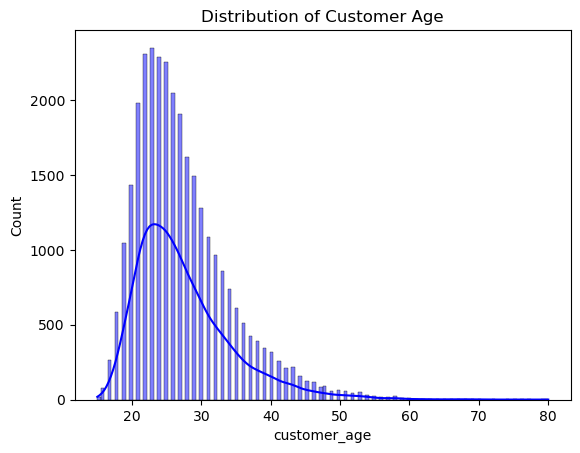

In [9]:
# get distribution of the 'customer_age' column
sns.histplot(df_customers['customer_age'], kde=True, color='blue')
plt.title('Distribution of Customer Age')


- Distribution is right-skewed, let's use the median over the mean

In [10]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill customer_age with the median value
customer_age_median = df_customers['customer_age'].median()  # 26
df_customers['customer_age'].fillna(customer_age_median, inplace=True)

# fill age_group with the respective age group (21-30)
df_customers['age_group'].fillna('21-30', inplace=True)

**Customer Region**

In [11]:
# since we created 'customer_city' we will drop this variable
df_customers.drop(columns='customer_region', inplace=True)

**First_Order** 
- Impute with the mean, median or mode doesn't make sense here. As those missing values represent 0.33% let's drop them

In [12]:
# ignore warnings
warnings.filterwarnings('ignore')

# drop rows where first_order is missing
df_customers.dropna(subset=['first_order'], inplace=True)

## Outliers

In [13]:
# columns which values range from 0 to 1 so they don't need to be scaled
cols_range_0_1 = ['vendor_loyalty_score','relative_cuisine_variety', 'chain_consumption']

# numerical features that represent categorical data
num_cat_features = ['customer_city', 'available_cuisines_city', 'cuisine_variety']

In [15]:
# get metric features
metric_features = df_customers.select_dtypes(include=[np.number]).columns.difference(num_cat_features + cols_range_0_1)
# get non-metric features
non_metric_features = df_customers.select_dtypes(exclude=[np.number]).columns

In [17]:
# scale the metric features for DBSCAN
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_customers[metric_features])

### 3.1 DBSCAN

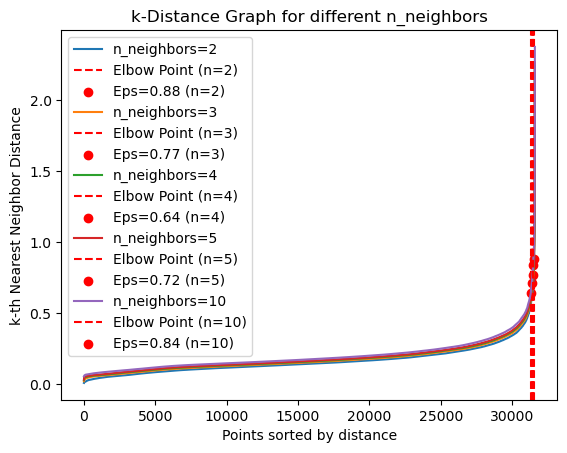

,n_neighbors,Elbow Index,Epsilon
0,2,31530,0.879009
1,3,31470,0.767117
2,4,31337,0.640417
3,5,31413,0.715630
4,10,31462,0.840211


In [18]:
# list of n_neighbors to test
n_neighbors_list = [2, 3, 4, 5, 10]

# empty lists to store results
elbow_indices = []
epsilons = []

# perform calculations for each n_neighbors
for n_neighbors in n_neighbors_list:
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data_scaled)
    distances, _ = nbrs.kneighbors(data_scaled)
    distances = np.sort(distances[:, n_neighbors - 1], axis=0)

    # use KneeLocator to find the elbow point
    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

    # get elbow point and epsilon
    elbow_index = kneedle.elbow
    epsilon = distances[elbow_index]

    # store results
    elbow_indices.append(elbow_index)
    epsilons.append(epsilon)

    # highlight the elbow point on the graph for each n_neighbors
    plt.plot(distances, label=f'n_neighbors={n_neighbors}')
    plt.axvline(x=elbow_index, color='r', linestyle='--', label=f'Elbow Point (n={n_neighbors})')
    plt.scatter(elbow_index, epsilon, color='red', label=f'Eps={epsilon:.2f} (n={n_neighbors})')

# DataFrame to store the results
df_results = pd.DataFrame({
    'n_neighbors': n_neighbors_list,
    'Elbow Index': elbow_indices,
    'Epsilon': epsilons
})

# customize the graph
plt.xlabel('Points sorted by distance')
plt.ylabel('k-th Nearest Neighbor Distance')
plt.title('k-Distance Graph for different n_neighbors')
plt.legend()
plt.show()

df_results


In [24]:
epsilon = np.linspace(0.6, 0.95, 20) # range of epsilon values to test based on table above
min_samples = np.arange(2, 12) # range of min_samples values to test based on table above

In [25]:
# get all possible combinations of epsilon and min_samples
combinations = list(itertools.product(epsilon, min_samples))
N = len(combinations)
N

200

In [26]:
# function to perform grid search for DBSCAN
def GridSearch(combinations, X):
    scores = []  # list to store silhouette scores
    all_label = []  # list to store labels for each combination

    # iterate over each combination of eps and min_samples
    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_model.labels_  # get the cluster labels
        labels_set = set(labels)  # convert labels to a set to find unique labels
        num_clusters = len(labels_set)  # number of unique clusters

        # adjust the number of clusters if noise points (-1) are present
        if -1 in labels_set:
            num_clusters -= 1

        # check if the number of clusters is within the desired range
        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-20)  # poor score for undesirable cluster counts
            all_label.append("Poor")  
            print(" at iteration:", i, "eps =", eps, "min_samples =", num_samples, "number of clusters =", num_clusters, "moving on ..")
            continue 

        # get silhouette score for the current clustering
        scores.append(silhouette_score(X, labels))
        all_label.append(labels)  # Store the labels
        print(" at iteration:", i, "score:", scores[-1], "Number of clusters:", num_clusters)

    # find the index of the best score
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]  # get the best parameters
    best_score = scores[best_index]  # get the best score

    # Return the best parameters, labels, and score as a dictionary
    return {
        'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_score': best_score
    }

In [29]:
# perform grid search
best_params = GridSearch(combinations, data_scaled)

 at iteration: 0 score: 0.40397823485220175 Number of clusters: 3
 at iteration: 1 ep = 0.6 min_samples = 3 number of clusters = 1 moving on ..
 at iteration: 2 ep = 0.6 min_samples = 4 number of clusters = 1 moving on ..
 at iteration: 3 ep = 0.6 min_samples = 5 number of clusters = 1 moving on ..
 at iteration: 4 ep = 0.6 min_samples = 6 number of clusters = 1 moving on ..
 at iteration: 5 ep = 0.6 min_samples = 7 number of clusters = 1 moving on ..
 at iteration: 6 ep = 0.6 min_samples = 8 number of clusters = 1 moving on ..
 at iteration: 7 ep = 0.6 min_samples = 9 number of clusters = 1 moving on ..
 at iteration: 8 ep = 0.6 min_samples = 10 number of clusters = 1 moving on ..
 at iteration: 9 ep = 0.6 min_samples = 11 number of clusters = 1 moving on ..
 at iteration: 10 score: 0.40365563859459075 Number of clusters: 3
 at iteration: 11 ep = 0.6184210526315789 min_samples = 3 number of clusters = 1 moving on ..
 at iteration: 12 ep = 0.6184210526315789 min_samples = 4 number of c

In [30]:
# display the best parameters
print(best_params)

{'best_epsilon': 0.8394736842105263, 'best_min_samples': 2, 'best_labels': array([0, 0, 0, ..., 0, 0, 0]), 'best_score': 0.6387891702220179}


In [31]:
# build the DBSCAN model with the best parameters
dbscan_final = DBSCAN(eps=0.8394736842105263, min_samples=2)
clusters = dbscan_final.fit_predict(data_scaled)

In [32]:
# identify outliers and print its count
outliers = data_scaled[clusters == -1]  
print(f"Outliers: {len(outliers)}")

Outliers: 59


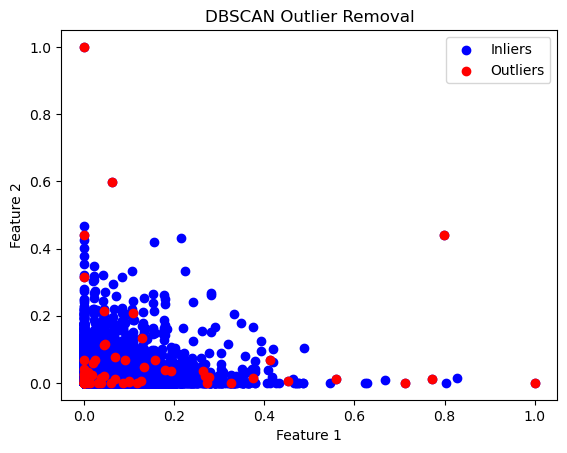

In [39]:
# using alpha for transparency
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c='blue', alpha=0.6, label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.6, label='Outliers')
plt.title('DBSCAN Outlier Removal')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


In [33]:
# calculate the percentage of data that are outliers
outliers_percentage = (len(outliers) / len(data_scaled)) * 100
print(f"Percentage of data identified as outliers: {outliers_percentage:.2f}%")

Percentage of data identified as outliers: 0.19%


## Prepare notebook for clustering

In [34]:
# remove outliers from the data
no_outliers = data_scaled[clusters != -1]
# turn into dataframe
df_final = pd.DataFrame(no_outliers, columns=metric_features, index=df_customers.index[clusters != -1])

In [36]:
# adding back the features that were removed in the beginning
df_final[cols_range_0_1] = df_customers[cols_range_0_1]
df_final[num_cat_features] = df_customers[num_cat_features]
df_final[non_metric_features] = df_customers[non_metric_features]

In [38]:
# export the final Dataframe
df_final.to_csv('df2.csv', index=True)